In [1]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Set some visual settings for charts
plt.style.use('ggplot')

In [2]:
# API configuration
BASE_URL = "https://live.euroleague.net/api/Points"
SEASON_CODE = "E2025"
TOTAL_GAMES = 35

# Team Codes for our main analysis
FENERBAHCE = "ULK"
ANADOLU_EFES = "IST"

In [3]:
def fetch_euroleague_data(game_count):
    """
    This function gets data from the EuroLeague API.
    It cleans team names and adds game codes.
    """
    all_data = []
    
    print(f"Starting to fetch {game_count} games...")
    
    for game_id in range(1, game_count + 1):
        params = {'gamecode': game_id, 'seasoncode': SEASON_CODE}
        
        try:
            # Request data with a timeout
            response = requests.get(BASE_URL, params=params, timeout=10)
            response.raise_for_status() # Check for HTTP errors
            
            data = response.json()
            rows = data.get("Rows", [])
            
            for row in rows:
                # Add game and season info
                row['GAME_CODE'] = game_id
                row['SEASON_CODE'] = SEASON_CODE
                # Clean team names: make them uppercase and remove spaces
                row['TEAM'] = row['TEAM'].upper().strip() if row['TEAM'] else ""
                all_data.append(row)
                
        except Exception as e:
            print(f"Error in game {game_id}: {e}")
        
        # Wait a little bit to be polite to the server
        time.sleep(0.2)
        
    return pd.DataFrame(all_data)

# Run the function
raw_df = fetch_euroleague_data(TOTAL_GAMES)
print(f"Data collection finished. Total rows: {len(raw_df)}")

Starting to fetch 35 games...
Data collection finished. Total rows: 5602


In [4]:
def process_team_metrics(df):
    """
    This function calculates averages for every team.
    It finds points scored, points conceded, and shot types.
    """
    # Convert points to numbers
    df['POINTS'] = pd.to_numeric(df['POINTS'], errors='coerce').fillna(0).astype(int)
    df['FASTBREAK'] = pd.to_numeric(df['FASTBREAK'], errors='coerce').fillna(0).astype(int)

    # 1. Calculate points scored per team per game
    game_stats = df.groupby(['GAME_CODE', 'TEAM']).agg(
        points_scored=('POINTS', 'sum'),
        points_3pt=('POINTS', lambda x: df.loc[x.index, 'POINTS'][df['ACTION'] == 'Three Pointer'].sum()),
        points_2pt=('POINTS', lambda x: df.loc[x.index, 'POINTS'][df['ACTION'] == 'Two Pointer'].sum()),
        points_fb=('POINTS', lambda x: df.loc[x.index, 'POINTS'][df['FASTBREAK'] == 1].sum())
    ).reset_index()

    # 2. Calculate points conceded
    total_game_pts = game_stats.groupby('GAME_CODE')['points_scored'].transform('sum')
    game_stats['points_conceded'] = total_game_pts - game_stats['points_scored']

    # 3. Calculate averages for all teams
    team_averages = game_stats.groupby('TEAM').mean().drop(columns=['GAME_CODE'])
    
    # 4. Prepare the final table for visualization
    metrics = ['points_scored', 'points_conceded', 'points_3pt', 'points_2pt', 'points_fb']
    league_avg = team_averages.mean()
    
    # Find the best value for each metric
    best_values = pd.Series({
        'points_scored': team_averages['points_scored'].max(),
        'points_conceded': team_averages['points_conceded'].min(),
        'points_3pt': team_averages['points_3pt'].max(),
        'points_2pt': team_averages['points_2pt'].max(),
        'points_fb': team_averages['points_fb'].max()
    })
    
    # Find the team code for the best values
    best_teams = [
        team_averages['points_scored'].idxmax(),
        team_averages['points_conceded'].idxmin(),
        team_averages['points_3pt'].idxmax(),
        team_averages['points_2pt'].idxmax(),
        team_averages['points_fb'].idxmax()
    ]
    
    # Create final analysis dataframe
    final_metrics_df = pd.DataFrame({
        'ULK': team_averages.loc[FENERBAHCE],
        'IST': team_averages.loc[ANADOLU_EFES],
        'League AVG': league_avg,
        'Best Team': best_values
    })
    
    return final_metrics_df, best_teams

# Process the data
analysis_df, best_team_codes = process_team_metrics(raw_df)
print("Team metrics are ready.")

Team metrics are ready.


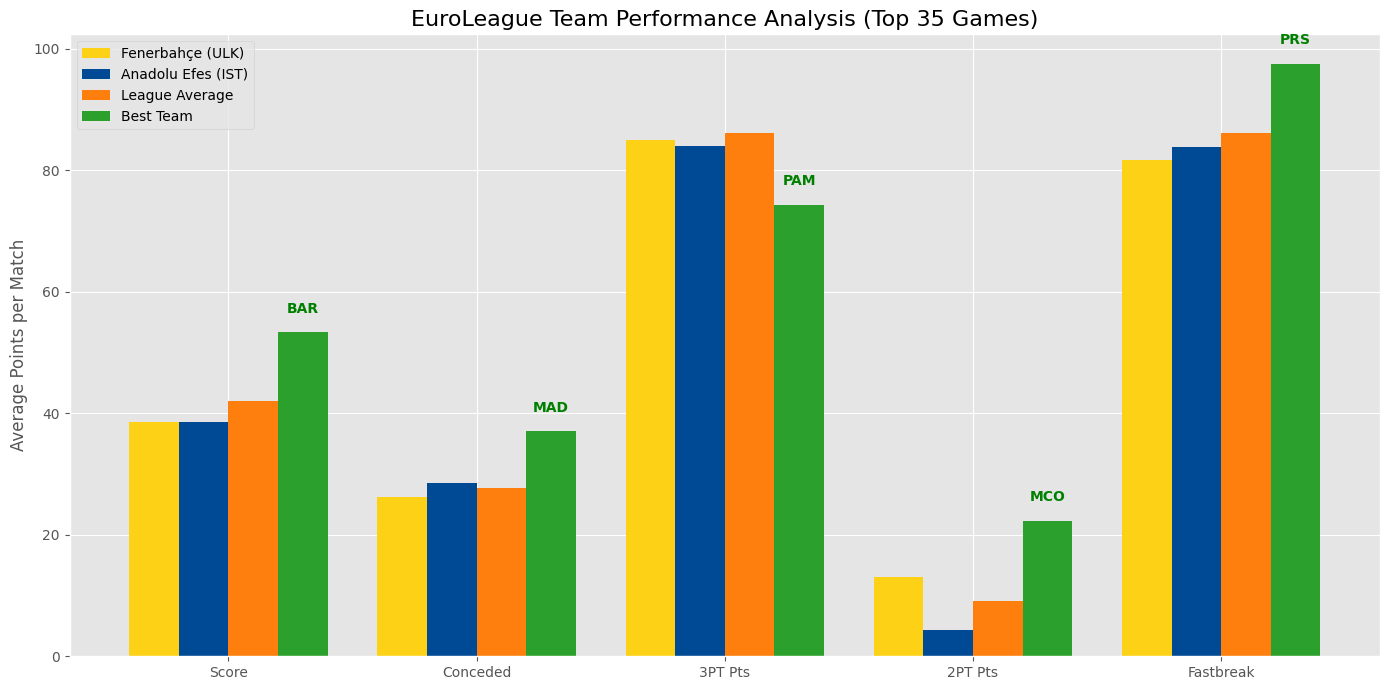

In [5]:
def create_performance_chart(metrics_df, best_codes):
    """
    This function creates a bar chart.
    It compares our teams with the league and the best teams.
    """
    labels = ['Score', 'Conceded', '3PT Pts', '2PT Pts', 'Fastbreak']
    x = np.arange(len(labels))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot bars
    ax.bar(x - 1.5*width, metrics_df.loc[:, 'ULK'], width, label='Fenerbahçe (ULK)', color='#fcd116')
    ax.bar(x - 0.5*width, metrics_df.loc[:, 'IST'], width, label='Anadolu Efes (IST)', color='#004a95')
    ax.bar(x + 0.5*width, metrics_df.loc[:, 'League AVG'], width, label='League Average', color='#ff7f0e')
    best_bars = ax.bar(x + 1.5*width, metrics_df.loc[:, 'Best Team'], width, label='Best Team', color='#2ca02c')
    
    # Add team codes above the green bars
    ax.bar_label(best_bars, labels=best_codes, padding=12, color='green', fontweight='bold')
    
    # Add chart details
    ax.set_title('EuroLeague Team Performance Analysis (Top 35 Games)', fontsize=16)
    ax.set_ylabel('Average Points per Match')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Create the chart
create_performance_chart(analysis_df, best_team_codes)

In [6]:
def get_shooter_recommendations(df):
    """
    This function finds the best shooters in the league.
    We look for players not in Fenerbahçe with high 3PT average.
    """
    # Filter 3-point shots
    shooters = df[df['ACTION'] == 'Three Pointer'].copy()
    
    # Calculate stats per player
    stats = shooters.groupby(['PLAYER', 'TEAM']).agg(
        total_3pt=('POINTS', 'sum'),
        games=('GAME_CODE', 'nunique')
    )
    
    stats['3pt_per_game'] = stats['total_3pt'] / stats['games']
    
    # Sort and filter
    recommendations = stats[stats.index.get_level_values('TEAM') != FENERBAHCE]
    return recommendations.sort_values('3pt_per_game', ascending=False).head(5)

# Show top 5 shooters
top_shooters = get_shooter_recommendations(raw_df)
print("\n--- Recruitment Suggestions for Fenerbahçe (Sharp-Shooters) ---")
print(top_shooters)


--- Recruitment Suggestions for Fenerbahçe (Sharp-Shooters) ---
                       total_3pt  games  3pt_per_game
PLAYER           TEAM                                
OBST, ANDREAS    MUN          45      3          15.0
HIFI, NADIR      PRS          39      3          13.0
HOWARD, MARKUS   BAS          24      2          12.0
SELJAAS, ZACHARY ASV          33      3          11.0
LARKIN, SHANE    IST          21      2          10.5
